In [43]:
from transformers import pipeline, set_seed

### Hugging face tutorial

In [44]:
generator = pipeline('text-generation', model='gpt2')

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
generator(txt, max_length=100)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'as he drove toward town he thought of nothing except a large order of drills he was hoping to get that day started and that night we got back in the car. But he couldn\'t get it done. He sat there on the ground, for all his senses, in the back seat of the car. Looking back, he says,\n\n"My father never told me his plan was to blow up. I know now I know what he told me."\n\nSo while I was waiting for'}]

### fastai experiment

In [9]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
import torch
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [7]:
text = 'Tripping on hallucinogenics'
encoded_input = tokenizer.encode(text)
encoded_input

[14824, 2105, 319, 23251, 259, 6644, 873]

In [8]:
tokenizer.decode(encoded_input)

'Tripping on hallucinogenics'

In [10]:
t1 = torch.LongTensor(encoded_input)[None]
preds = model.generate(t1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [11]:
preds

tensor([[14824,  2105,   319, 23251,   259,  6644,   873,   318,   257,  2219,
          3357,   287,   262,  1578,  1829,    13,   198,   198,   464,  2563]])

In [12]:
tokenizer.decode(preds[0])

'Tripping on hallucinogenics is a common practice in the United States.\n\nThe drug'

### integrate with fastai

In [49]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
    def encodes(self, x):
        toks = self.tokenizer.tokenize(x)
        return tensor(
            self.tokenizer.convert_tokens_to_ids(toks)
        )
    
    def decodes(self,x):
        return TitledStr(self.tokenizer.decode(x.cpu()))

- in encodes we don't use the tokenizer.encode method since it does some additional preprocessing for the model after tokenizing and numericalizing (the part throwing a warning before). Here we don't need any post-processing so it's fine to skip it.
- in decodes we return a TitledStr object and not just a plain string. That's a fastai class that adds a show method to the string, which will allow us to use all the fastai show methods.

## 03-16

In [1]:
from fastai.text.all import *
import torch
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel,GPT2PreTrainedModel
import re
import codecs
import chardet

In [2]:
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [3]:
path = Path('../data/harrypotter')

In [4]:
file_pths = path.ls(file_type='txt').sorted()
file_pths = [p for p in file_pths if p.suffix == '.txt']
file_pths

[Path('../data/harrypotter/hp1.txt'),
 Path('../data/harrypotter/hp2.txt'),
 Path('../data/harrypotter/hp3.txt'),
 Path('../data/harrypotter/hp4.txt'),
 Path('../data/harrypotter/hp5.txt'),
 Path('../data/harrypotter/hp6.txt'),
 Path('../data/harrypotter/hp7.txt')]

In [5]:
def detect_encoding(pth):
    '''
        resp: {'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}
    '''
    with open(pth,'rb') as f:
        c = chardet.detect(f.read())
#         if c['encoding'] != 'utf-8':
        return c

def read_text_in_file(pth,detect_enco=False):
    arr = []
    encoding = detect_encoding(pth)['encoding'] if detect_enco else 'utf-8'
    with open(pth,encoding=encoding) as f:
        line = f.readline()
        while(line):
            arr+=[line]
            line = f.readline()
    return arr

def to_utf8(pth,origin_encoding):
    if origin_encoding == 'utf-8':
        return
    
    o_pth = pth
    
    with open(pth, 'r', encoding=origin_encoding) as f:
        txt = f.read()
    new_pth = pth.rename(
        pth.parent
        /(pth.name.replace(pth.suffix,'')+'_old'+pth.suffix)
    )
    with open(o_pth, 'w', encoding='utf-8') as f:
        f.write(txt)
def re_encode(pths):
    for pth in pths:
        c = detect_encoding(pth)
        if c['encoding'] != 'utf-8':
            to_utf8(pth, c['encoding'])
            print(pth,'DONE')

In [6]:
# def _find_page_in_line(txt):
#     res = re.findall(r'.+(Page\s\d{1,}).+',txt)
#     return len(res) > 0
def clean_text_data(book):
    book = [t for t in book if len(t.strip()) > 0]
#     book = [t for t in book if not _find_page_in_line(t)]
    return book

def count_n_of_txt(arr):
    c = 0
    for t in arr:
        c += len(t.strip())
    return c

In [7]:
books = [read_text_in_file(pth) for pth in file_pths]

In [8]:
books = [clean_text_data(b) for b in books]

In [9]:
#special procession
books[4] = [l.strip() for l in books[4]]

In [10]:
[count_n_of_txt(b) for b in books]

[434129, 484354, 618222, 1100404, 1478532, 979007, 1120173]

In [11]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

class TransformersTokenizer(Transform):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
#     def encodes(self, x):
#         toks = self.tokenizer.tokenize(x)
#         return tensor(
#             self.tokenizer.convert_tokens_to_ids(toks)
#         )
    
    def decodes(self,x):
        return TitledStr(self.tokenizer.decode(x.cpu()))


class DropOutput(Callback):
    def after_pred(self):
        self.learn.pred = self.pred[0]

In [12]:
def split_data(data,pct=0.9):
    res = []
    res2 = []
    for o in data:
        stop_idx = int(len(o)*0.9)
        res.append(o[:stop_idx])
        res2.append(o[stop_idx:])
    split_idx = len(sum(res,[]))
    flatten_res = sum(res+res2,[])
    return flatten_res, [range(0,split_idx), range(split_idx, len(flatten_res))]

In [13]:
data,splits = split_data(books,0.9)

In [14]:
len(data), splits

(38335, [range(0, 34497), range(34497, 38335)])

In [15]:
tokenized = [tokenize(t) for t in data]
tls = TfmdLists(data, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=8,seq_len=512)

In [16]:
x,y = dls.train.one_batch()

In [144]:
tokenizer.decode(x[0])

'\t"Did he, now?" said Madam Pomfrey approvingly. "So we\'ve finally got a Defense Against the Dark Arts teacher who knows his remedies?"\n“So, it isn’t necessary to kill the previous owner to take the possession of a wand?” asked Harry.\nHarry\'s heart skipped several beats.\t"Eleven Sickles," said Stan, "but for fifteen you get \'or chocolate, and for fifteen you get an \'ot water bottle an\' a toofbrush in the color of your choice."\nKrum’s jaw muscles worked as if he were chewing, then he said, “Grindelvald killed many people, my grandfather, for instance. Of course, he vos never powerful in this country, they said he feared Dumbledore—and rightly, seeing how he vos finished. But this”—he pointed a finger at Xenophilius—“this is his symbol, I recognized it at vunce: Grindelvald carved it into a vall at Durmstrang ver he vos a pupil there. Some idiots copied it onto their books and clothes thinking to shock, make themselves impressive—until those of us who had lost family members to

In [16]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=[accuracy, Perplexity()]).to_fp16()

In [17]:
learn.validate()

(#3) [3.34389591217041,0.36050447821617126,28.329280853271484]

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.10000000149011612)

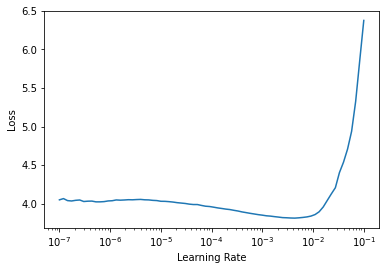

In [18]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(2,3e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.266488,3.142713,0.368330,23.166630,01:29
1,3.048096,3.082181,0.377244,21.805920,01:29


SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.17378008365631104)

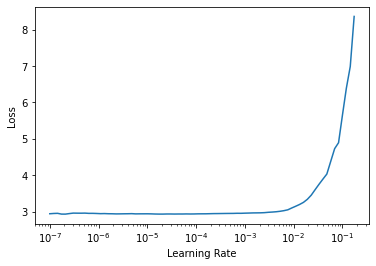

In [20]:
learn.lr_find()

In [22]:
learn.unfreeze()
learn.fit_one_cycle(30, slice(1e-5/(2.6**4), 1e-5))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.841350,3.086767,0.377659,21.906151,01:30
1,2.831483,3.088636,0.377170,21.947115,01:28
2,2.817164,3.089906,0.377188,21.975006,01:28
3,2.827383,3.089430,0.377552,21.964546,01:29
4,2.826955,3.088039,0.377410,21.934027,01:31
5,2.815834,3.089407,0.377693,21.964043,01:29
6,2.801037,3.087946,0.377880,21.931982,01:30
7,2.805175,3.088624,0.377785,21.946863,01:29
8,2.792917,3.088498,0.378105,21.944096,01:29
9,2.786904,3.091213,0.377474,22.003742,01:29


In [21]:
learn.save('./04-27-hp-gpt2')

Path('models/04-27-hp-gpt2.pth')

In [168]:
learn.summary()

GPT2LMHeadModel (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 256 x 768       
Embedding                                 38597376   True      
Embedding                                 786432     True      
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 256 x 2304      
Conv1D                                    1771776    True      
Conv1D                                    590592     True      
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 256 x 3072      
Conv1D                                    23623

In [64]:
learn.model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

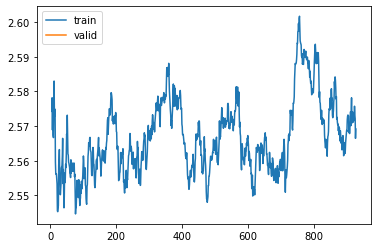

In [65]:
learn.recorder.plot_loss()

In [75]:
??model.generate

In [48]:
modelc = model.cpu()

In [98]:
txt = "as he drove toward town he thought of nothing except a large order of drills he was hoping to get that day"
ids = tokenizer.encode(txt)
inp = tensor(ids)[None]
beam_search_and_ngram = {
    'num_beams':5,
    #'num_return_sequences':5, # <=beams
    'no_repeat_ngram_size':2,
    
}
top_k_sampling = {
    'do_sample':True,
    'top_k':50
}

top_p = {
    'do_sample':True,
    'top_p': 0.92,
    'top_k': 50
}
preds = modelc.generate(inp, max_length=100,
                        pad_token_id=tokenizer.eos_token_id,
                    #     repetition_penalty=1.5,
                    #     top_p=0.92,
                        temperature=.7,
                        early_stopping=True,
                        **top_p
                                                )
print(preds.shape)

torch.Size([1, 100])


In [99]:
tokenizer.decode(preds[0].cpu(),skip_special_tokens=True)

'as he drove toward town he thought of nothing except a large order of drills he was hoping to get that day, and of course, the fact that the Ministry was already working on a means of extracting him from Azkaban. \n\'We\'ll have to,\' said Ron, taking the bag and holding it up to his eyes. \'We\'ll have to.\'"What d\'you mean?" Harry asked.\n"No," said Harry, looking at her.\n"Oh, no'

In [25]:
data[10]

"It was on the corner of the street that he noticed the first sign of something peculiar -- a cat reading a map. For a second, Mr. Dursley didn't realize what he had seen -- then he jerked his head around to look again. There was a tabby cat standing on the corner of Privet Drive, but there wasn't a map in sight. What could he have been thinking of? It must have been a trick of the light. Mr. Dursley blinked and stared at the cat. It stared back. As Mr. Dursley drove around the corner and up the road, he watched the cat in his mirror. It was now reading the sign that said Privet Drive -- no, looking at the sign; cats couldn't read maps or signs. Mr. Dursley gave himself a little shake and put the cat out of his mind. As he drove toward town he thought of nothing except a large order of drills he was hoping to get that day.\n"

In [111]:
modules = learn.model.modules()

In [112]:
modules = list(modules)

In [121]:
book1_encodings = tokenizer(books[0], truncation=True, padding=True)

In [96]:
tokenizer.pad_token = tokenizer.eos_token

In [101]:
book1_encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [105]:
GPT2PreTrainedModel??